<a href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/adan_tf2/notebooks/08_Main_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applied Deep Learning in Intracranial Neurophysiology Workshop
### Adversarial Domain Adaptation for Stable Brain-Machine Interfaces https://arxiv.org/pdf/1810.00045.pdf

This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL), prepared generously by [Dr. Ali Farshchian](https://www.researchgate.net/profile/Ali_Farshchian). The original version can be found on his [GitHub page](https://github.com/farshchian/ADAN).

<table><td><a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/08_01_ADAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td></table>

### Dependencies

In [1]:
# Normalize local and google colab environments.
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    os.chdir('..')
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    # !pip install -q tensorflow-gpu==2.0.0-rc0
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)

Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 1193 (delta 33), reused 27 (delta 12), pack-reused 1127
Receiving objects: 100% (1193/1193), 312.40 MiB | 39.66 MiB/s, done.
Resolving deltas: 100% (710/710), done.
Checking out files: 100% (93/93), done.


In [0]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
from indl.adan import utils
from indl import reset_keras
from tqdm import tqdm_notebook

plt.rcParams.update({'font.size': 22})

### Loading Data

In [0]:
datadir = Path.cwd() / 'data' / 'ADAN'
data = {}
for i, f in enumerate(datadir.glob('*.mat')):
    raw_data = sio.loadmat(datadir/f, squeeze_me=True)
    data['rate' + str(i)], data['EMG' + str(i)] = utils.load_data(raw_data)

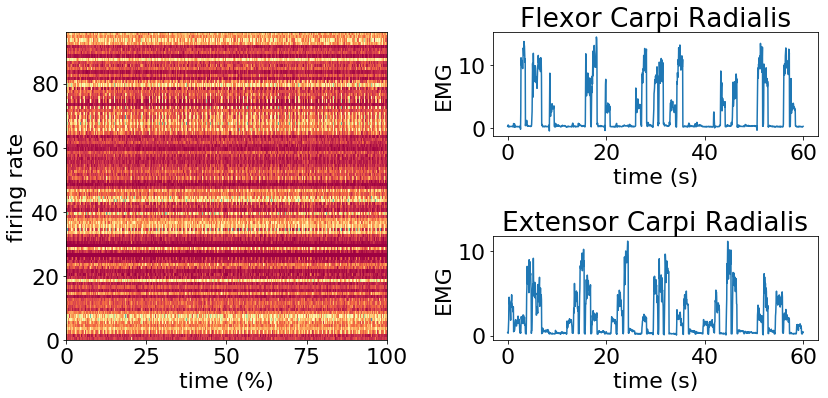

In [4]:
plt.figure(figsize=(12,6), facecolor='white')

plt.subplot(2, 2, (1,3))
plt.imshow(np.transpose(data['rate0']),cmap='Spectral',extent=[0,100,0,96])
plt.xlabel('time (%)')
plt.ylabel('firing rate')

plt.subplot(2, 2, 2)
t = np.linspace(0., 60., 1200, endpoint=True)
plt.plot(t,data['EMG0'][:1200,0])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Flexor Carpi Radialis')

plt.subplot(2, 2, 4)
plt.plot(t,data['EMG0'][:1200,11])
plt.xlabel('time (s)')
plt.ylabel('EMG')
plt.title('Extensor Carpi Radialis')

plt.tight_layout()
plt.show()

## Day-0 Decoder
![ADAN](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/ADAN.png?raw=1)

### Decoder Hyperparameters

In [0]:
spike_dim = 96
emg_dim = 14
latent_dim = 10
batch_size = 64
n_steps = 4
n_layers = 1
n_epochs = 40
lr = 0.001
gamma = 1

### Decoder Graph

In [21]:
reset_keras()
n_units=[64, 32, latent_dim]
spk_input = tf.keras.layers.Input(shape=(4, 96,), name='enc_input')
emg_input = tf.keras.layers.Input(shape=(4, 14,), name='emg_input')
h1 = tf.keras.layers.Dense(units=n_units[0], activation=tf.nn.elu, name='enc_0')(spk_input)
h2 = tf.keras.layers.Dense(units=n_units[1], activation=tf.nn.elu, name='enc_1')(h1)
latent = tf.keras.layers.Dense(units=n_units[2], activation=None, name='enc_lat')(h2)
h3 = tf.keras.layers.Dense(units=n_units[1], activation=tf.nn.elu, name='dec_lat')(latent)
h4 = tf.keras.layers.Dense(units=n_units[0], activation=tf.nn.elu, name='dec_1')(h3)
spk_hat = tf.keras.layers.Dense(units=96, activation=tf.nn.elu, name='spk_out')(h4)
# _latent = np.zeros((n_steps, latent.shape[1]))
# for j in range(n_steps-1):
#   _latent[j, :] = np.mean(latent[j*(BIN_DURATION - BIN_OVRLP):j*(BIN_DURATION - BIN_OVRLP) + BIN_DURATION, :], axis=0)
# latent1 = tf.keras.layers.Flatten()(latent)
# latent2 = tf.keras.layers.Dense(units=40, activation=tf.nn.relu)(latent)
# latent3 = tf.convert_to_tensor(latent, dtype=tf.float32)
# print(type(latent))
# _latent = tf.keras.layers.Reshape((4, 10))(latent)
# # _latent = tf.keras.layers.Reshape((None, n_units[2]))(latent)
# h5 = tf.keras.layers.LSTM(emg_dim, return_sequences=False, stateful=False, name='dec_emg_0')(_latent)
h5 = [tf.keras.layers.LSTMCell(emg_dim, activation=tf.nn.elu)
              for _ in range(n_layers)]
h6 = tf.keras.layers.StackedRNNCells(h5)
h7 = tf.keras.layers.RNN(h6, return_sequences=True, name='dec_emg_rnn')(latent)
emg_hat = tf.keras.layers.Dense(units=emg_dim, activation=None, name='emg_out')(h7)
# emg_hat = tf.keras.layers.Reshape((-1,emg_dim), name='emg_out')(h8)
model = tf.keras.Model(inputs=[spk_input,emg_input], outputs=[spk_hat, emg_hat])
model.summary()
# def make_model(spk_dim, emg_dim, n_steps, n_rnn_layers, n_units=[64, 32, latent_dim]):
    # Define encoder
# _spk = tf.keras.layers.Input(shape=(spike_dim,) , name='enc_input')
# # _emg = tf.keras.layers.Input(shape=(None,emg_dim), name='dec_input')
# _y = tf.keras.layers.Dense(units=n_units[0], activation=tf.nn.elu, name='enc_0')(_spk)
# _y = tf.keras.layers.Dense(units=n_units[1], activation=tf.nn.elu, name='enc_1')(_y)
# _latent = tf.keras.layers.Dense(units=n_units[2], activation=None, name='enc_lat')(_y)

# # Define spike decoder - latent as input
# _y = tf.keras.layers.Dense(units=n_units[1], activation=tf.nn.elu, name='dec_lat')(_latent)
# _y = tf.keras.layers.Dense(units=n_units[0], activation=tf.nn.elu, name='dec_spk_1')(_y)
# _spk_hat = tf.keras.layers.Dense(units=spike_dim, activation=tf.nn.elu, name='dec_spk_0')(_y)

# # Define emg decoder - also has latent as input
# #     _y2 = tf.reshape(_latent,[-1,n_steps,latent_dim])
# _y2 = tf.keras.layers.Reshape((n_steps,latent_dim), name='dec_emg_reshape_in')(_latent)
# _cells = [tf.keras.layers.LSTMCell(emg_dim, activation=tf.nn.elu)
#           for _ in range(n_layers)]
# _stacked_cell = tf.keras.layers.StackedRNNCells(_cells)
# _y2 = tf.keras.layers.RNN(_stacked_cell, name='dec_emg_rnn')(_latent)
# _y2 = tf.keras.layers.Dense(units=emg_dim, activation=None, name='dec_emg_fc')(_y2)
# _emg_hat = tf.keras.layers.Reshape((-1, emg_dim), name='dec_emg_reshape_out')(_y2)

# model = tf.keras.Model(inputs=_spk, outputs=(_spk_hat, _emg_hat))

# #     # TODO: model.add_loss ... but will that work with gamma?
# #     total_loss, new_gamma = model_loss(_spk, _emg, _spk_hat, _emg_hat, gamma)
# #     model.add_loss(total_loss)
# #     return model

# # reset_keras()
# # model = make_model(spike_dim, emg_dim, n_steps, n_layers, n_units=[64, 32, latent_dim])
# model.summary()

0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 4, 96)]      0                                            
__________________________________________________________________________________________________
enc_0 (Dense)                   (None, 4, 64)        6208        enc_input[0][0]                  
__________________________________________________________________________________________________
enc_1 (Dense)                   (None, 4, 32)        2080        enc_0[0][0]                      
__________________________________________________________________________________________________
enc_lat (Dense)                 (None, 4, 10)        330         enc_1[0][0]                      
____________________________________________________________________________________________

In [0]:
def ae_loss(spk, spk_hat):
  return tf.reduce_mean(tf.square(spk_hat - spk))
def emg_loss(emg, emg_hat):
  return tf.reduce_mean(tf.square(emg_hat - emg))
losses = {
    "spk_out" : ae_loss,
    "emg_out" : emg_loss,
}
weights = {
    "spk_out" : gamma,
    "emg_out": 1.0
}
# gamma = tf.reduce_mean(tf.square(emg_hat - emg)) / tf.reduce_mean(tf.square(spk_hat - spk))

In [0]:
spike_day0 = data['rate0']
emg_day0 = data['EMG0']
idx = int((len(spike_day0)//n_steps)*n_steps*0.82)
r = len(spike_day0)%n_steps

spike_tr = spike_day0[:idx]
spike_tr = np.reshape(spike_tr, [-1, 4, 96])
emg_tr = emg_day0[:idx]
emg_tr = np.reshape(emg_tr, [-1, 4, 14])
spike_te = spike_day0[idx:-r]
spike_te = np.reshape(spike_te, [-1, 4, 96])
emg_te = emg_day0[idx:-r]
emg_te = np.reshape(emg_te, [-1, 4, 14])

In [0]:
model.compile(optimizer='adam',
              loss=losses,
              loss_weights=weights,
              metrics=['accuracy'])

In [23]:
model.fit([spike_tr,emg_tr], [spike_tr,emg_tr],
                epochs=n_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=([spike_te,emg_te], [spike_te,emg_te]))

Train on 1202 samples, validate on 264 samples
Epoch 1/40
1202/1202 [==============================] - 1s 994us/sample - loss: 21.4522 - spk_out_loss: 4.6748 - emg_out_loss: 16.7349 - spk_out_acc: 0.0121 - emg_out_acc: 0.0774 - val_loss: 17.4444 - val_spk_out_loss: 2.3102 - val_emg_out_loss: 15.5454 - val_spk_out_acc: 0.0265 - val_emg_out_acc: 0.0843
Epoch 2/40
1202/1202 [==============================] - 0s 184us/sample - loss: 15.0504 - spk_out_loss: 1.5824 - emg_out_loss: 13.4685 - spk_out_acc: 0.0680 - emg_out_acc: 0.1175 - val_loss: 12.5986 - val_spk_out_loss: 0.9610 - val_emg_out_loss: 11.4001 - val_spk_out_acc: 0.0767 - val_emg_out_acc: 0.1619
Epoch 3/40
1202/1202 [==============================] - 0s 175us/sample - loss: 12.1773 - spk_out_loss: 0.9141 - emg_out_loss: 11.2496 - spk_out_acc: 0.0680 - emg_out_acc: 0.1980 - val_loss: 10.9218 - val_spk_out_loss: 0.8532 - val_emg_out_loss: 9.6502 - val_spk_out_acc: 0.0455 - val_emg_out_acc: 0.2330
Epoch 4/40
1202/1202 [==============

In [0]:
[spk_repro, emg_repro] = model.predict(x=[spike_te, emg_te])

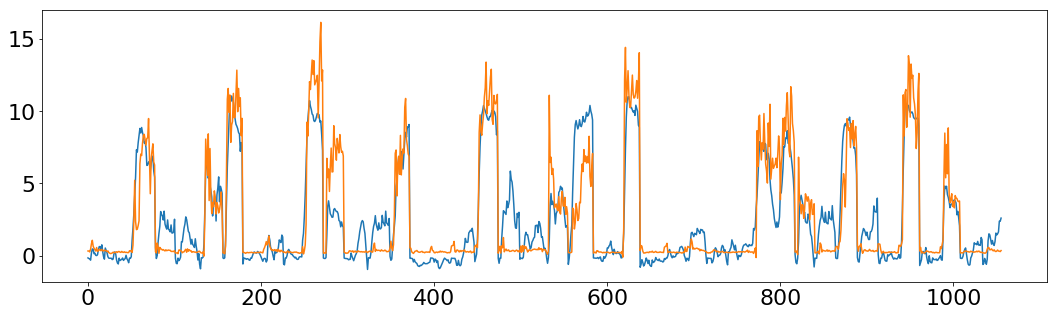

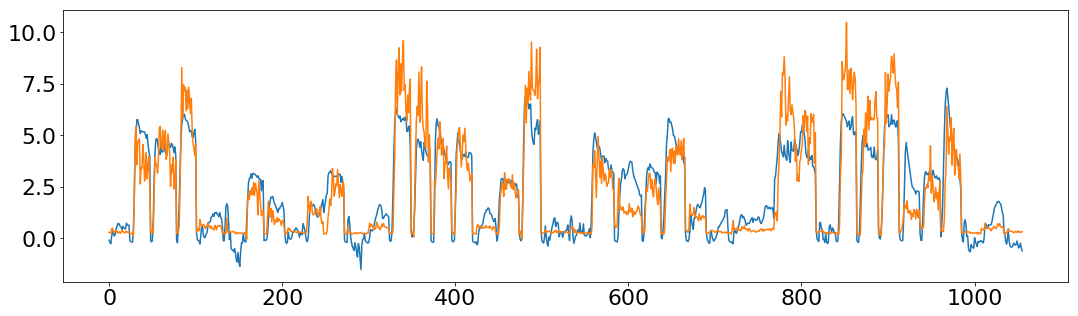

In [25]:
emg_repro_1 = np.reshape(emg_repro, [-1, 14])
emg_te_1 = np.reshape(emg_te, [-1, 14])

# for i in range(10):
#   plt.figure(i)
plt.figure(figsize=(18, 5))
plt.plot(emg_repro_1[:, 0])
plt.plot(emg_te_1[:, 0])

plt.figure(figsize=(18, 5))
plt.plot(emg_repro_1[:, 11])
plt.plot(emg_te_1[:, 11])